<a href="https://colab.research.google.com/github/Fouad-Mhz/mri_classification/blob/main/test_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Classification Using Deep Learning

## Project Overview

1. This project is aimed at developing a deep learning model to classify MRI scans into different phases of a disease. The project involves the use of various deep learning models and techniques, including custom Convolutional Neural Networks (CNNs), an optimized VGG model, and transfer learning with EfficientNetB0.

2.  The data used in this project consists of MRI scans of patients in different phases of a disease. The data is split into training, validation, and test sets. Data augmentation techniques are used to increase the size of the training set and reduce overfitting.

3.  The models are trained using different optimizers and batch sizes, and their performance is evaluated using various metrics, including accuracy, loss, precision, recall, F1 score, and AUC. The models' performance is analyzed, and suggestions for improvement are provided.

4.  The final model is saved and can be used to predict the phase of a disease given a new MRI scan. The project also includes a function to display random images from the original and transformed datasets, providing a visual understanding of the data augmentation process.

5.  The application is dockerized for ease of deployment, and the code is versioned using Git and hosted on a public repository. The project includes a detailed README file that provides information

## Installation

To install the necessary dependencies, you can use the provided `requirements.txt` file:

# requirements.txt

lion-tf==0.0.1
numpy==1.21.2
pandas==1.3.3
matplotlib==3.4.3
tensorflow==2.6.0
split-folders==0.4.3
sklearn==0.24.2
efficientnet==1.1.1
scikit-image==0.18.3
cv2==4.5.3
PIL==8.3.2


# Readme file: MRI Phase Classification

This project is focused on the development and deployment of a deep learning model for classifying MRI scans into different phases of a disease. The project involves the use of various deep learning models and techniques, including custom Convolutional Neural Networks (CNNs), and transfer learning with EfficientNetB0.

## Data

The data used in this project consists of MRI scans of patients in different phases of a disease. The data is split into training, validation, and test sets. Data augmentation techniques are used to increase the size of the training set and reduce overfitting.

## Models

Several models are trained and evaluated in this project:

1. A custom Convolutional Neural Network (CNN).
2. A model using transfer learning with EfficientNetB0.

The models are trained using different optimizers and batch sizes. The performance of the models is evaluated using various metrics, including accuracy, loss, precision, recall, F1 score, and AUC.

## Evaluation

The performance of the models is analyzed, and suggestions for improvement are provided. The final model is saved and can be used to predict the phase of a disease given a new MRI scan.

## Dockerization

The application is dockerized for ease of deployment. This allows the model to be run in any environment that supports Docker, without the need for installing specific dependencies.

## Version Control

The code for this project is versioned using Git and hosted on a public repository. This allows for easy tracking of changes and collaboration.


## Conclusion

This project demonstrates the use of deep learning for medical image classification. It provides a starting point for further research and development in this area.

# **Helper functions**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! pip install lion-tf
! pip install split-folders[full]

## Import

### Import libraries and functions

In [4]:
# Standard library imports
import os
import random
from shutil import copyfile

# Third-party imports for data handling and analysis
import numpy as np
import pandas as pd

# Image processing and metrics
import cv2
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.transform import resize, warp
from skimage.filters import gaussian

# Plotting
import matplotlib.pyplot as plt

# Machine learning and metrics
from sklearn.utils import validation
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    precision_recall_fscore_support,
    roc_auc_score,
)

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, Activation, Add, DepthwiseConv2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.regularizers import l2

# For splitting data into train/validation/test sets
import splitfolders

# Custom module
import lion_tf
from lion_tf import Lion




### Load dataset

In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []

    for filename in os.listdir(folder):
        image = Image.open(os.path.join(folder, filename))
        if image is not None and image.size != (0, 0):
            images.append(image)
            label = os.path.splitext(filename)[0]  # Get the filename without the extension
            labels.append(label)


    return images, labels

def load_dataset(original_dataset_path):
    images = []
    labels = []
    phases = ['EO', 'IO', 'IPTE', 'LO', 'PTE']
    for phase in phases:
        phase_images, phase_labels = load_images_from_folder(os.path.join(original_dataset_path, phase))
        images.extend(phase_images)
        labels.extend(phase_labels)

    return images, labels

## Transformations

### Resize, adjust contrast, deblur , disortortion and denoise

In [ ]:
def adjust_contrast(image, factor):
    adjusted_image = cv2.convertScaleAbs(image, alpha=factor)
    return adjusted_image

def apply_distortion(image, distortion_factor):
    rows, cols, _ = image.shape  # Unpack the shape of the color image
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    map_x = x + distortion_factor * np.sin(y / 20)
    map_y = y + distortion_factor * np.cos(x / 20)
    
    # Apply distortion to each color channel separately
    distorted_image = np.zeros_like(image)
    for i in range(image.shape[2]):
        distorted_image[:, :, i] = cv2.remap(image[:, :, i], map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR)
    
    return distorted_image

def apply_fastNlMeansDenoising(image):   
    denoised_image = cv2.fastNlMeansDenoisingColored (image, None, h=0, hColor=0 ,templateWindowSize=7, searchWindowSize=21)
    return denoised_image

### Quality assessment

In [ ]:
def calculate_quality_score(image, original_image):
    # Convert the images to numpy arrays
    image1 = np.array(image)
    image2 = np.array(original_image)

    # Calculate the maximum pixel value for the data type
    if image1.dtype == np.uint8:
        max_pixel_value = 255
    elif image1.dtype == np.float64:
        max_pixel_value = 1.0
    else:
        max_pixel_value = np.max(image1)
    
    # Calculate the PSNR
    quality_score = psnr(image1, image2, data_range=max_pixel_value)

    return quality_score

### Apply transformations

In [ ]:
def apply_transformations(image):
    # Reshape and convert images to arrays
    image = np.array(image.resize((224, 224)))
    image = np.stack((image,) * 3, axis=-1)
    best_quality_score = 0
    best_transformed_image = image.copy()

    # Define the transformations and their parameters
    transformations = [
        {'name': 'FastNlMeansDenoising', 'function': apply_fastNlMeansDenoising,'params': {}},
        {'name': 'Apply Distortion', 'function': apply_distortion, 'params': {'distortion_factor': 0.1}},
        {'name': 'Adjust Contrast', 'function': adjust_contrast, 'params': {'factor': 1.1}}]

    for transformation in transformations:
            
            # Apply the transformation
            transformed_image = transformation['function'](best_transformed_image, **transformation['params'])
            # Check if transformation is successful and image data is valid
            if transformed_image is None or np.isnan(transformed_image).any() or np.isinf(transformed_image).any():
                print(f"Transformation {transformation['name']} failed or resulted in invalid image data. Skipping this transformation.")      
                continue
            # Compare the quality scores only if the dimensions and color/grayscale match
            quality_score = calculate_quality_score(transformed_image, image)    
            if np.isnan(quality_score) or np.isinf(quality_score):
                print(f"Quality score calculation after transformation {transformation['name']} resulted in invalid value. Skipping this transformation.")
                continue
            if quality_score > best_quality_score:
                best_quality_score = quality_score
                best_transformed_image = transformed_image
            # print(f"Quality score after transformation {transformation['name']}: {quality_score}")
            # print(f"Best quality score: {best_quality_score}")
                       
    return best_transformed_image

### Create the transformed dataset

In [ ]:
# Define the paths
original_dataset_path = '/content/Dataset/train/'
transformed_dataset_path = '/content/transformed_data/'

def copy_dataset(original_dataset_path, transformed_dataset_path):
    # Create the transformed dataset directory if it doesn't exist
    os.makedirs(transformed_dataset_path, exist_ok=True)

    # Iterate through the original dataset directory
    for root, dirs, files in os.walk(original_dataset_path):
        for file in files:
            # Get the original image path
            original_image_path = os.path.join(root, file)

            # Get the relative path by removing the original_dataset_path
            relative_path = os.path.relpath(original_image_path, original_dataset_path)

            # Get the corresponding transformed image path
            transformed_image_path = os.path.join(transformed_dataset_path, relative_path)

            # Create the destination directory if it doesn't exist
            os.makedirs(os.path.dirname(transformed_image_path), exist_ok=True)

            # Copy the original image to the transformed dataset path
            copyfile(original_image_path, transformed_image_path)
            
def transform_dataset(transformed_dataset_path):
    # Copy the dataset to the transformed dataset path
    copy_dataset(original_dataset_path, transformed_dataset_path)
    # Iterate through the transformed dataset directory
    for root, _, files in os.walk(transformed_dataset_path):
        for file in files:
            # Get the transformed image path
            transformed_image_path = os.path.join(root, file)
            
            # Load the transformed image
            transformed_image = Image.open(transformed_image_path)
            
            # Apply transformations to the image
            transformed_image = apply_transformations(transformed_image)
            
            # Convert the transformed image to PIL Image object
            transformed_image = Image.fromarray(transformed_image)
            
            # Save the transformed image, overwriting the original
            transformed_image.save(transformed_image_path, 'JPEG',overwrite=True)

### Display images

In [ ]:
def display_random_images(original_dataset_path, transformed_dataset_path):
    # Load the images from the original dataset
    original_images, original_labels = load_dataset(original_dataset_path)

    # Load the transformed images from the transformed dataset
    transformed_images, transformed_labels = load_dataset(transformed_dataset_path)

    # Randomly select 4 pairs of images
    random_indices = random.sample(range(len(original_images)), 4)

    # Create a figure with 4 subplots
    fig, axs = plt.subplots(2, 4, figsize=(10, 5))
    fig.subplots_adjust(hspace=7)
    fig.subplots_adjust(wspace=7)

    # Iterate over the randomly selected pairs of images
    for i, index in enumerate(random_indices):
        original_image = original_images[index]
        transformed_image = transformed_images[index]
        original_label = os.path.basename(os.path.dirname(original_labels[index]))

        # Calculate the position in the grid
        row = i // 2
        col = i % 2

        # Display the original image on the left subplot
        axs[row, 2*col].imshow(original_image)
        axs[row, 2*col].axis('off')
        axs[row, 2*col].set_title(original_label, fontsize=12, pad=10)

        # Display the transformed image on the right subplot
        axs[row, 2*col + 1].imshow(transformed_image)
        axs[row, 2*col + 1].axis('off')
        axs[row, 2*col + 1].set_title(original_label, fontsize=12, pad=10)

    plt.tight_layout()
    plt.show()

## Data processing

### Data augmentation (ImageDataGenerator)

In [ ]:
# Define the data generators
def create_data_generators(model, batch_size):

  train_generator = train_datagen.flow_from_directory(
      directory=train_dir,
      target_size=IMG_SIZE,
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=True,
      seed=seed)

  validation_generator = validation_datagen.flow_from_directory(
      directory=validation_dir,
      target_size=IMG_SIZE,
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=False,
      seed=seed)

  test_generator = test_datagen.flow_from_directory(directory=test_dir,
      target_size=IMG_SIZE,
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=False,
      seed=seed)
  
  return train_generator, validation_generator, test_generator,

In [ ]:
# Define the class weights
def compute_weights(train_generator):
  # Get the class labels from the generator
  class_labels = np.unique(train_generator.classes)
  # Get the encoded labels from the generator
  y = train_generator.classes
  # Calculate class weights
  class_weights = compute_class_weight(
      class_weight = "balanced",
      classes = class_labels,
      y = y)
  class_weights = dict(zip(class_labels, class_weights))
  return class_weights

## Model training

### Callbacks and metrics functions

In [ ]:
class PerformanceMetrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_generator):
        super(PerformanceMetrics, self).__init__()
        self.validation_generator = validation_generator
        self.precision_scores = []
        self.recall_scores = []
        self.f1_scores = []
        self.auc_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_val = self.validation_generator.classes
        y_pred = self.model.predict(self.validation_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_classes, average='macro', zero_division=1)
        auc = roc_auc_score(y_val, y_pred, multi_class='ovr')

        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.f1_scores.append(f1)
        self.auc_scores.append(auc)

        if logs is not None:
            logs['val_precision'] = round(precision, 2)
            logs['val_recall'] = round(recall, 2)
            logs['val_f1'] = round(f1, 2)
            logs['val_auc'] = round(auc, 2)

        # print(f' - val_precision: {round(precision, 3):.3f} - val_recall: {round(recall, 3):.3f} - val_f1: {round(f1, 3):.3f} - val_auc: {round(auc, 3):.3f}')

# Define the EarlyStopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss score
    mode='min',  #  Minimize the validation loss score
    patience=3,  # Stop training if no improvement for 3 epochs
    restore_best_weights=True  # Restore the best model weights
)

### Training model and evaluation

In [ ]:
model_dir = '/content/drive/MyDrive/model/'
# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

In [ ]:
def create_and_train_model(model, optimizer, batch_size):

    train_generator, validation_generator, test_generator = create_data_generators(model, batch_size) #class_labels, class_weights,
    class_weights = compute_weights(train_generator)

    print(f"Training model with {optimizer.__class__.__name__} optimizer and batch size of {batch_size}")
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                  metrics=['accuracy'])

    performance_callback = PerformanceMetrics(validation_generator)

    # Create a filename with the format: optimizer_batchsize
    filename = f'{optimizer.__class__.__name__}_{batch_size}.h5'
    name = 'CNN/'

    # Add the directory path to the filename
    filepath = model_dir + name + filename

    # Define the ModelCheckpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1, custom_objects={'Lion': Lion})

    history = model.fit(
        train_generator,
        steps_per_epoch= train_generator.n// train_generator.batch_size,
        epochs=8,
        validation_data=validation_generator,
        validation_steps=validation_generator.n // validation_generator.batch_size,
        # class_weight=class_weights,
        callbacks=[early_stopping_cb, performance_callback, 
                   #checkpoint_callback
                   ]
        )
    # Save the model to a file
    model.save(filepath)
    print(f'Model saved as {filename}')

    # Return history and histories
    return history

In [ ]:
def train_models(model):
    histories = []
    for optimizer in optimizers:
        for batch_size in batch_sizes:
            history = create_and_train_model(model, optimizer, batch_size)
            histories.append(history)
    return histories

### Models architecture: From scratch & transfer learning

In [ ]:
# The optimized  VGG

def optimized_block(x, filters, kernel_size=(3, 3), strides=(1, 1)):
    # Depthwise separable convolution
    x = DepthwiseConv2D(kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Skip connection
    if strides != (1, 1):
        shortcut = Conv2D(filters, (1, 1), strides=strides)(x)
        shortcut = BatchNormalization()(shortcut)
        x = Add()([x, shortcut])
    return x
def OptimizedVGG(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = optimized_block(inputs, 32) # 32 filters
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = optimized_block(x, 64)  # 64 filters
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = optimized_block(x, 256)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)  # Dense layer with 256 neurons
    x = Dropout(0.5)(x)  # Dropout added
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model


In [ ]:
# Model from scratch

def classifier(input_shape, num_classes):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape = input_shape ))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  return model

In [ ]:
#  EfficientNetB0 model for transfer learning

def efficientnet_model(base_model, num_classes):

  # Freeze the layers in the base model
  base_model.trainable = False

  inputs = base_model.input
  x = BatchNormalization()(base_model.output)
  x = optimized_block(x, 256)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2), strides=(2, 2))(x)
  x = Flatten()(x)
  x = Dropout(0.4)(x)
  outputs = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

# **Main script**

## Preprocessing

### Data augmentation

### Applying the transformations

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data split into Train,Validation and test data
splitfolders.ratio("/content/drive/MyDrive/Test", output="Dataset",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False) 

Copying files: 1285 files [00:03, 389.85 files/s]


In [ ]:
original_dataset_path = '/content/Dataset/train/'
corrupt_files_path = '/content/corrupt_files/'
transformed_dataset_path = '/content/Transformed_data/'

transform_dataset(transformed_dataset_path)

In [ ]:
# Data augmentation for model from scratch

train_dir = '/content/Transformed_data/'
validation_dir = '/content/Dataset/val'
test_dir = '/content/Dataset/test'

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        zoom_range=0.3,
        width_shift_range=0.5,
        height_shift_range=0.5,
        shear_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=17,
        fill_mode="nearest",)

validation_datagen = ImageDataGenerator(
        rescale=1 / 255.0)

test_datagen = ImageDataGenerator(
        rescale=1 / 255.0)

### Displaying random images (original vs transformed)

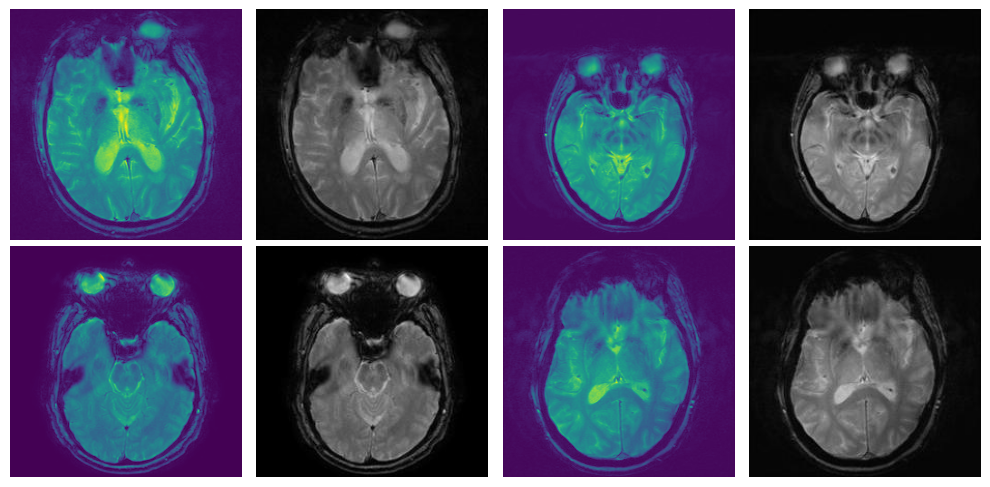

In [ ]:
display_random_images(original_dataset_path, transformed_dataset_path)

## Training the model

### Model 1 (from scratch)

In [ ]:
# Train the models

seed = 42
IMG_SIZE = (224, 224)
input_shape=(224, 224,3)
num_classes = 5


# Define your optimizers, batch sizes, and model
K.clear_session()
batch_sizes = [32, 64, 128]
optimizers = [Lion(), tf.keras.optimizers.Adam(), tf.keras.optimizers.SGD()]
histories_b0 = []

# model = OptimizedVGG(input_shape, num_classes)
model = classifier(input_shape, num_classes)


# Train the models
histories = train_models(model)

Found 898 images belonging to 5 classes.
Found 256 images belonging to 5 classes.
Found 131 images belonging to 5 classes.
Training model with Lion optimizer and batch size of 32
Epoch 1/8
28/28 [==============================] - 21s 379ms/step - loss: 1.5376 - accuracy: 0.3880 - val_loss: 1.4526 - val_accuracy: 0.4453 - val_precision: 0.8900 - val_recall: 0.2000 - val_f1: 0.1200 - val_auc: 0.4800
Epoch 2/8
28/28 [==============================] - 11s 375ms/step - loss: 1.4757 - accuracy: 0.4273 - val_loss: 1.4351 - val_accuracy: 0.4453 - val_precision: 0.8900 - val_recall: 0.2000 - val_f1: 0.1200 - val_auc: 0.4700
Epoch 3/8
28/28 [==============================] - 11s 378ms/step - loss: 1.4829 - accuracy: 0.4226 - val_loss: 1.4332 - val_accuracy: 0.4453 - val_precision: 0.8900 - val_recall: 0.2000 - val_f1: 0.1200 - val_auc: 0.4900
Epoch 4/8
28/28 [==============================] - 11s 375ms/step - loss: 1.4600 - accuracy: 0.4434 - val_loss: 1.4371 - val_accuracy: 0.4453 - val_precisi

#### Aalyzing the results:

Looking at the results, we can make the following observations:


1.   Loss and Accuracy: The loss values are relatively high for all optimizers, indicating that the models are not performing optimally. Similarly, the accuracy values are relatively low, suggesting that the models are struggling to classify the data accurately.

2.   Validation Loss and Validation Accuracy: The validation loss and validation accuracy values are consistent with the training results. They also indicate that the models are not generalizing well to unseen data, as the validation loss is similar to the training loss and the validation accuracy is similar to the training accuracy.

3.   Precision, Recall, and F1 Score: The precision, recall, and F1 score provide insights into the model's performance for positive predictions. These values are moderate, indicating that the models have a reasonable balance between correctly predicting positive instances (precision) and capturing all positive instances (recall).

4.   AUC: The AUC values measure the overall performance of the models. The values are relatively high, suggesting that the models are performing better than random guessing. However, they are not exceptionally high, indicating that there is room for improvement.

Overall, the models trained with different optimizers and batch sizes have similar performance, with no significant variations in their metrics.

### Model 2 (transfer learning)

In [ ]:
batch_size = 64
num_classes = 5

# Data augmentation for EfficientNet

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input) 
validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=seed)

validation_generator = validation_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=seed)

test_generator = test_datagen.flow_from_directory(directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=seed)

Found 898 images belonging to 5 classes.
Found 256 images belonging to 5 classes.
Found 131 images belonging to 5 classes.


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss score
    mode='min',  #  Minimize the validation loss score
    patience=3,  # Stop training if no improvement for 3 epochs
    restore_best_weights=True  # Restore the best model weights
    )

In [ ]:
  K.clear_session()
  # EfficientNetB0
  base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

In [ ]:
optimizers = [Lion(), tf.keras.optimizers.Adam(), tf.keras.optimizers.SGD()] 
class_weights = compute_weights(train_generator)
performance_callback = PerformanceMetrics(validation_generator)

histories_b0 = []
for opt in optimizers:
  optimizer_name = type(opt).__name__  # Get the class name of the optimizer
  print(f"Training model with {opt.__class__.__name__} optimizer and batch size of {batch_size}")
  efficientnet = efficientnet_model(base_model, num_classes)
  efficientnet.compile(loss='categorical_crossentropy', optimizer=opt, 
              metrics=['accuracy'])
  
  history = efficientnet.fit(
    train_generator,
    steps_per_epoch= train_generator.n// train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    # class_weight=class_weights,
    callbacks=[early_stopping_cb, performance_callback,
               #checkpoint_callback
               ]
    )

  # Add the directory path to the filename
  
  filename = f'{optimizer_name}_{batch_size}'
  filepath = '/content/drive/MyDrive/model/Efficientnet_B0/' + filename

  # Save the model to a file
  tf.saved_model.save(efficientnet, filepath)
  efficientnet.save_weights(filepath)
  print(f'weights saved')
  print(f'Model saved as {filename} in {filepath}')
  histories_b0.append(history)

Training model with Lion optimizer and batch size of 64
Epoch 1/10
14/14 [==============================] - 13s 479ms/step - loss: 2.9673 - accuracy: 0.2938 - val_loss: 1.6140 - val_accuracy: 0.1445 - val_precision: 0.1600 - val_recall: 0.1700 - val_f1: 0.1200 - val_auc: 0.4800
Epoch 2/10
14/14 [==============================] - 3s 244ms/step - loss: 2.5910 - accuracy: 0.3465 - val_loss: 1.6291 - val_accuracy: 0.1172 - val_precision: 0.6400 - val_recall: 0.1800 - val_f1: 0.0900 - val_auc: 0.5000
Epoch 3/10
14/14 [==============================] - 3s 244ms/step - loss: 2.4051 - accuracy: 0.3609 - val_loss: 1.6423 - val_accuracy: 0.1133 - val_precision: 0.6400 - val_recall: 0.1700 - val_f1: 0.0800 - val_auc: 0.5200
Epoch 4/10
14/14 [==============================] - 4s 252ms/step - loss: 2.3022 - accuracy: 0.3873 - val_loss: 1.6546 - val_accuracy: 0.1367 - val_precision: 0.1600 - val_recall: 0.1700 - val_f1: 0.1200 - val_auc: 0.4800


weights saved
Model saved as Lion_64 in /content/drive/MyDrive/model/Efficientnet_B0/Lion_64
Training model with Adam optimizer and batch size of 64
Epoch 1/10
14/14 [==============================] - 15s 478ms/step - loss: 3.4334 - accuracy: 0.3214 - val_loss: 1.5961 - val_accuracy: 0.2070 - val_precision: 0.7200 - val_recall: 0.2200 - val_f1: 0.1000 - val_auc: 0.5600
Epoch 2/10
14/14 [==============================] - 4s 251ms/step - loss: 2.1283 - accuracy: 0.4796 - val_loss: 1.6120 - val_accuracy: 0.1797 - val_precision: 0.4700 - val_recall: 0.2000 - val_f1: 0.0800 - val_auc: 0.5800
Epoch 3/10
14/14 [==============================] - 3s 249ms/step - loss: 1.3966 - accuracy: 0.5695 - val_loss: 1.6068 - val_accuracy: 0.1875 - val_precision: 0.8400 - val_recall: 0.2000 - val_f1: 0.0600 - val_auc: 0.6000
Epoch 4/10
14/14 [==============================] - 3s 267ms/step - loss: 1.0557 - accuracy: 0.6799 - val_loss: 1.6429 - val_accuracy: 0.1211 - val_precision: 0.7200 - val_recall: 0.22

weights saved
Model saved as Adam_64 in /content/drive/MyDrive/model/Efficientnet_B0/Adam_64
Training model with SGD optimizer and batch size of 64
Epoch 1/10
14/14 [==============================] - 14s 494ms/step - loss: 8.2705 - accuracy: 0.3022 - val_loss: 1.5807 - val_accuracy: 0.3242 - val_precision: 0.2800 - val_recall: 0.2400 - val_f1: 0.1800 - val_auc: 0.5700
Epoch 2/10
14/14 [==============================] - 3s 243ms/step - loss: 5.4914 - accuracy: 0.3345 - val_loss: 1.5552 - val_accuracy: 0.3711 - val_precision: 0.3900 - val_recall: 0.2700 - val_f1: 0.2700 - val_auc: 0.5600
Epoch 3/10
14/14 [==============================] - 3s 243ms/step - loss: 6.5798 - accuracy: 0.3597 - val_loss: 1.6516 - val_accuracy: 0.1875 - val_precision: 0.8400 - val_recall: 0.2100 - val_f1: 0.0800 - val_auc: 0.5500
Epoch 4/10
14/14 [==============================] - 3s 243ms/step - loss: 4.9178 - accuracy: 0.3777 - val_loss: 1.5889 - val_accuracy: 0.1953 - val_precision: 0.6100 - val_recall: 0.220

weights saved
Model saved as SGD_64 in /content/drive/MyDrive/model/Efficientnet_B0/SGD_64


#### Aalyzing the results:

Overall observations:

All optimizers had suboptimal performance.

*   Struggled to learn from training data (high training losses).
*   Limited generalization ability (high validation losses).
*   Low precision, recall, and F1 score for positive predictions.
*   AUC values indicated better-than-random performance, but room for improvement.


Overall, all three optimizers showed suboptimal performance. They struggled to learn from the training data, resulting in high training losses and relatively low training accuracies. The models also exhibited limited generalization ability, as indicated by high validation losses and modest validation accuracies. The precision, recall, and F1 scores were consistently low across the optimizers, suggesting difficulties in accurately predicting positive instances. The AUC values indicated that the models performed better than random guessing, but there is still room for improvement in their ability to differentiate between positive and negative instances.

## Evaluation of the model

In [14]:
path_model = '/content/drive/MyDrive/model/CNN/Lion_128.h5'
image_path = '/content/drive/MyDrive/Test/LO/neuroflux_002_S_4447_MR_Axial_T2-Star__br_raw_20150205115705094_22_S247813_I472270.jpg'

IMG_SIZE = (224, 224)

# Predict phase
def predict_phase(image_path):

    # Load the saved model with custom optimizer
    model = load_model(path_model, custom_objects={'Lion': Lion()})

    # Define the labels
    class_labels = ['EO', 'IO', 'IPTE', 'LO', 'PTE']
    IMG_SIZE = (224, 224)  

    # Load the image
    img = load_img(image_path, target_size=IMG_SIZE)

    # Convert the image to a numpy array
    img_array = img_to_array(img)

    # Rescale the image
    img_array = img_array / 255.0

    # Expand the dimensions to match the shape that the model expects
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100

    # Extract the true label from the file path
    true_label = os.path.basename(os.path.dirname(image_path))

    print(f"The MRI scan most likely belongs to {class_labels[predicted_class]} with a {confidence:.2f}% confidence.")
    print(f"The true label is {true_label}.")

predict_phase(image_path)



1/1 [==============================] - 0s 72ms/step
The MRI scan most likely belongs to PTE with a 40.15% confidence.
The true label is LO.


In [ ]:
test_dir = '/content/drive/MyDrive/Test'
batch_size = 128
seed = 42

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

# Evaluate the model
test_generator = test_datagen.flow_from_directory(directory=test_dir, target_size=IMG_SIZE,
                                                  batch_size=batch_size, class_mode="categorical",
                                                  shuffle=False, seed=seed)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps = test_generator.n // test_generator.batch_size)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

1/1 [==============================] - 0s 489ms/step - loss: 1.4346 - accuracy: 0.4297
Test loss: 1.4345979690551758
Test accuracy: 0.4296875


#### Comments

The test result shows an accuracy of 42.97% and a loss of 1.4346. Here's a concise summary of the analysis and opinion, along with a comment on data exploration:



*   Accuracy: 42.97%
*   Loss: 1.4346
*   Overall model performance: Suboptimal
*   Generalization capability: Limited


1.   Suggestions for improvement: Further optimization, exploration of alternative architectures, tuning hyperparameters, increasing training data, and utilizing advanced techniques such as regularization or data augmentation.

2.    data exploration: A more in-depth analysis of the data is recommended to understand its characteristics, identify class imbalances or potential biases, assess the relevance and quality of features, and apply preprocessing techniques if necessary.

In summary, the model shows suboptimal performance with relatively low accuracy and moderate loss. Improvements are needed, including additional optimization efforts and a better understanding of the data.

1/1 [==============================] - 0s 190ms/step
The MRI scan most likely belongs to PTE with a 40.15% confidence.
The true label is LO.


#### Comments

The model's prediction for the MRI scan indicates a 44.25% confidence that it belongs to PTE, but it is actually labeled as LO. This suggests that the model's prediction is incorrect, highlighting the need for further improvements in its accuracy. 

# bonus: Stacking Ensemble

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lightgbm import LGBMClassifier
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score, precision_score, log_loss


# Define the base source path
source_base_path = '/content/drive/MyDrive/model/CNN/'

# Define the names of your models
model_names = ['Lion_32', 'Lion_64', 'Lion_128', 'SGD_32', 'SGD_64', 'SGD_128', 'Adam_32', 'Adam_64', 'Adam_128']

# Load the models
models = []
for model_name in model_names:
    model = load_model(source_base_path + f'{model_name}.h5', custom_objects={'Lion': Lion})
    models.append(model)

batch_size = 128
IMG_SIZE = (224, 224)
seed = 42
    
# Create an image data generator for the test data directory
test_datagen = ImageDataGenerator(rescale=1 / 255.0)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=seed
)


# Split the test generator into training and validation subsets
test_filenames = test_generator.filenames
test_labels = test_generator.labels
train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    test_filenames, test_labels, train_size=0.5, stratify=test_labels, random_state=42
)

# Create the training generator
train_generator2 = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_filenames, 'label': train_labels.astype(str)}),
    directory=test_dir,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Create the validation generator
val_generator2 = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_filenames, 'label': val_labels.astype(str)}),
    directory=test_dir,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

In [ ]:
# Define the meta-model using LightGBM
meta_model = LGBMClassifier(objective='multiclass', num_class=5)

# Make predictions with base models
predictions = []
for model in models:
    prediction = model.predict(train_generator2)
    predictions.append(prediction)

# Stack predictions
stacked_predictions = np.column_stack(predictions)

# Fit your meta-model
meta_model.fit(stacked_predictions, train_generator2.classes)

# Make final prediction with meta-model
final_prediction = meta_model.predict(stacked_predictions)

1/1 [==============================] - 0s 190ms/step


In [ ]:
# Save the model to a file
pickle.dump(meta_model, open("/content/drive/MyDrive/model/meta_model.pkl", "wb"))

# Load the model from the file
loaded_model = pickle.load(open("meta_model.pkl", "rb"))

# Make predictions with base models
val_predictions = []
for model in models:
    prediction = model.predict(val_generator2)
    val_predictions.append(prediction)

# Stack predictions
stacked_val_predictions = np.column_stack(val_predictions)

# Make final prediction with the meta-model
final_val_prediction = meta_model.predict(stacked_val_predictions)




# Calculate accuracy
accuracy = accuracy_score(val_labels, final_val_prediction)

# Calculate F1 score
f1 = f1_score(val_labels, final_val_prediction, average='weighted', zero_division=1)

# Calculate recall
recall = recall_score(val_labels, final_val_prediction, average='weighted', zero_division=1)

# Calculate precision
precision = precision_score(val_labels, final_val_prediction, average='weighted', zero_division=1)



print('Model accuracy:', accuracy)
print('Model F1 score:', f1)
print('Model recall:', recall)
print('Model precision:', precision)


1/1 [==============================] - 0s 179ms/step
Model accuracy: 0.3787878787878788
Model F1 score: 0.35519949606636914
Model recall: 0.3787878787878788
Model precision: 0.4108780108780109


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
image_path = '/content/Dataset/test/IPTE/neuroflux_024_S_4169_MR_AXIAL_T2_STAR__br_raw_20150824183510226_22_S269703_I506435.jpg'
img = image.load_img(image_path, target_size=IMG_SIZE)

# Convert the image to a numpy array and normalize it
img_array = image.img_to_array(img) / 255.0

# Expand the dimensions of the image array to match the input shape of your models
img_array = np.expand_dims(img_array, axis=0)

# Make predictions with base models
predictions = []
for model in models:
    prediction = model.predict(img_array)
    predictions.append(prediction)

# Stack predictions
stacked_predictions = np.column_stack(predictions)

# Make final prediction with the loaded meta-model
final_prediction = loaded_model.predict(stacked_predictions)

print('Final prediction:', final_prediction)

1/1 [==============================] - 0s 22ms/step
Final prediction: [4]
